# First run eda_customers!

In [30]:
import pandas as pd
tx = pd.read_parquet("../data/processed/transactions_canonical.parquet")
tx = tx.drop(columns=["invoiceEmail", "orderLineId"], errors="ignore")

a = pd.read_parquet("../data/processed/articles_clean.parquet", columns=["sku", "groupId", 'category', 'brand'])

In [31]:
print(len(tx))

313800


In [32]:
cols = ["groupId", "sku", "category", "brand"]
a_dedup = a[cols].drop_duplicates(subset=["groupId", "sku"])

tx = tx.merge(
    a_dedup,
    on=["groupId", "sku"],
    how="left",
    validate="many_to_one"  # raises if duplicates (groupId, sku)
)

In [33]:
# Save all rows where both category and brand are unknown/missing/na/none among those are articles that should be avoided later in recs as they are delivery related expenses
def is_unknown(val):
    if pd.isna(val):
        return True
    s = str(val).strip().lower()
    return s in {"unknown", "none", "na", ""}

mask = tx.apply(
    lambda row: is_unknown(row["category"]) and is_unknown(row["brand"]),
    axis=1
)

unknown_rows = tx[mask].drop_duplicates(subset=["sku"])
unknown_rows.to_csv("/workspace/data/processed/avoid_names.csv", sep="\t", index=False)


In [34]:
tx.isna().mean()

orderId        0.000000
shopUserId     0.000000
created        0.000000
currencyId     0.000000
sku            0.000000
groupId        0.000000
quantity       0.000000
price          0.000000
name           0.000000
type           0.000000
invoiceCity    0.000000
category       0.000003
brand          0.000003
dtype: float64

In [35]:
# Output rows where the price value is 6 digits or more
six_digit_price_rows = tx[tx['price'].astype(str).str.replace('.0$', '', regex=True).str.fullmatch(r'\d{6,}')]
six_digit_price_rows

# For rows where price is exactly 6 digits, set price to the last 3 digits (449399.0 to 399.0)
mask_six_digit = tx['price'].astype(str).str.replace('.0$', '', regex=True).str.fullmatch(r'\d{6}')
# Fix prices in-place for those rows
def fix_six_digit_price(val):
    s = str(val).strip().replace('.0', '')
    if len(s) == 6 and s.isdigit():
        return float(s[-3:])
    return val

tx.loc[mask_six_digit, 'price'] = tx.loc[mask_six_digit, 'price'].apply(fix_six_digit_price)


In [36]:
print(len(tx))

313800


## Remove known bugs

In [37]:
# Keep only rows where 'created' date is on or after 2024-06-01 to avoid migration bugs
tx['created'] = pd.to_datetime(tx['created'], errors='coerce')
tx = tx[tx['created'] >= pd.to_datetime('2024-06-01')]

In [38]:
print(len(tx))

310072


In [39]:
tx.head()

,orderId,shopUserId,created,currencyId,sku,groupId,quantity,price,name,type,invoiceCity,category,brand
0,873458,915527,2025-10-08 13:44:36,40,260596-2095,260596,1,429,BH uden bøjle Stars,telephone,Frederiksberg,"Bh utan bygel,Bh,Underkläder",Swegmark
1,873458,915527,2025-10-08 13:44:36,40,262287,262287,1,129,Knæstøtte 2-pak,telephone,Frederiksberg,Stödartiklar,Good Living
2,873458,915527,2025-10-08 13:44:36,40,291195,291195,1,139,Rygsmører,telephone,Frederiksberg,"Hudvård,Kroppsvård,Badrum/WC,Vardagshjälpmedel",Good Living
3,873458,915527,2025-10-08 13:44:36,40,290265,290265,1,449,Blodtryksmåler håndled,telephone,Frederiksberg,"Medicin,Hälsa",beurer
4,873456,915525,2025-10-08 13:44:18,134,280056-0041,280056,1,1500,Vinterkänga med dubb,telephone,Lidköping,"Skor,Skor & tofflor",Åshild


## Unify currenies to SEK for price bucketing

In [40]:
import pandas as pd
import requests

currencyid_to_country = {
    "40":  "DK",
    "134": "SE",
    "103": "NO",
    "50":  "FI",
}

def fetch_sek_rates():
    resp = requests.get(
        "https://api.frankfurter.app/latest",
        params={"from": "EUR", "to": "SEK,DKK,NOK"},
        timeout=10,
    )
    resp.raise_for_status()
    rates = resp.json()["rates"]
    sek_per_eur = rates["SEK"]
    dkk_per_eur = rates["DKK"]
    nok_per_eur = rates["NOK"]
    return {
        "DK": sek_per_eur / dkk_per_eur,
        "NO": sek_per_eur / nok_per_eur,
        "SE": 1.0,
        "FI": sek_per_eur,
    }

tx["currencyId"] = tx["currencyId"].astype("string").str.strip()
tx["currency_country"] = tx["currencyId"].map(currencyid_to_country)
conversion_rates = fetch_sek_rates()
tx["sek_rate"] = tx["currency_country"].map(conversion_rates)
tx["price"] = pd.to_numeric(tx["price"], errors="coerce")
tx["price_sek"] = (tx["price"] * tx["sek_rate"]).round(0).astype("Int64")


count      310071.0
mean     296.118866
std      247.861431
min             0.0
25%           142.0
50%           234.0
75%           417.0
max          7003.0
Name: price_sek, dtype: Float64


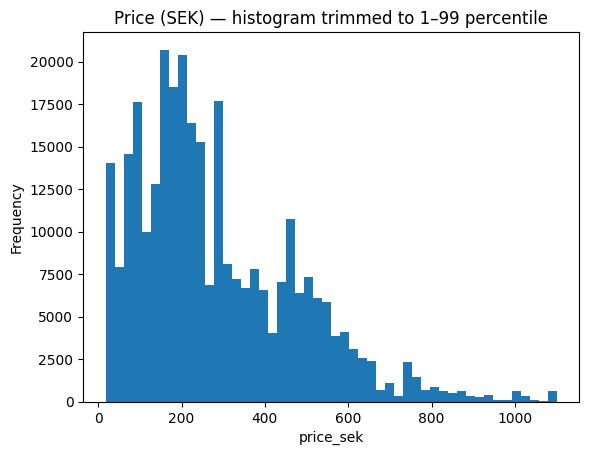

In [41]:
import matplotlib.pyplot as plt

s = tx["price_sek"]
print(s.describe())

q = s.quantile([0.01, 0.99])

t = s[s.between(q.loc[0.01], q.loc[0.99])]
plt.figure()
plt.hist(t, bins=50)
plt.title("Price (SEK) — histogram trimmed to 1–99 percentile")
plt.xlabel("price_sek")
plt.ylabel("Frequency")
plt.show()


In [42]:
customers = pd.read_parquet("../data/processed/customers_clean.parquet")
tx = tx.merge(customers[["shopUserId", "Age", "Gender"]], on="shopUserId", how="left")

In [43]:
# Keep customers where age is between 10 and 105, or where age is NaN
tx = tx[
    (tx['Age'].isna()) |
    ((tx['Age'] <= 105) & (tx['Age'] >= 10))
]

In [44]:
tx.isna().mean()

orderId             0.000000
shopUserId          0.000000
created             0.000000
currencyId          0.000000
sku                 0.000000
groupId             0.000000
quantity            0.000000
price               0.000003
name                0.000000
type                0.000000
invoiceCity         0.000000
category            0.000003
brand               0.000003
currency_country    0.000000
sek_rate            0.000000
price_sek           0.000003
Age                 0.357098
Gender              0.357098
dtype: float64

In [45]:
tx["type"].unique()


array(['telephone', 'letter', 'web', 'other', 'email'], dtype=object)

# Line price

In [46]:
tx["quantity"] = pd.to_numeric(tx["quantity"], errors="coerce").round().astype("Int64").astype(str)


In [47]:
tx["quantity"].unique()


array(['1', '2', '4', '3', '5', '8', '6', '10', '14', '7', '12', '16',
       '9', '11', '15', '50', '176', '130', '19', '40', '20', '229', '24',
       '18', '25', '999', '<NA>'], dtype=object)

In [48]:
# Calculate line_total_sek as price_sek * quantity, ensuring both are numeric, rounded to nearest integer (no decimals), and drop rows where result is NA or 0
tx["price_sek"] = pd.to_numeric(tx["price_sek"], errors="coerce")
tx["quantity"] = pd.to_numeric(tx["quantity"], errors="coerce")
tx["line_total_sek"] = (tx["price_sek"] * tx["quantity"]).round()
# Ensure line_total_sek is numeric
tx["line_total_sek"] = pd.to_numeric(tx["line_total_sek"], errors="coerce")
# Drop rows where line_total_sek is NA or 0
tx = tx.dropna(subset=["line_total_sek"])
tx = tx[tx["line_total_sek"] != 0]


 Country remap COUNTRY_MAP_ALPHA = {"SE": "Sweden", "DK": "Denmark", "FI": "Finland", "NO": "Norway"}

In [49]:
COUNTRY_MAP_ALPHA = {"SE": "Sweden", "DK": "Denmark", "FI": "Finland", "NO": "Norway"}
tx["country"] = tx["currency_country"].map(COUNTRY_MAP_ALPHA).fillna(tx["currency_country"])
tx = tx.drop(columns=["currency_country"])


In [50]:
tx['shopUserId'].nunique()


61455

In [51]:
tx.to_parquet("../data/processed/transactions_clean.parquet", index=False)